<a href="https://colab.research.google.com/github/Poseidon0007/Adobe-gensolve-image-detection/blob/main/opencvshapeandsymmetry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

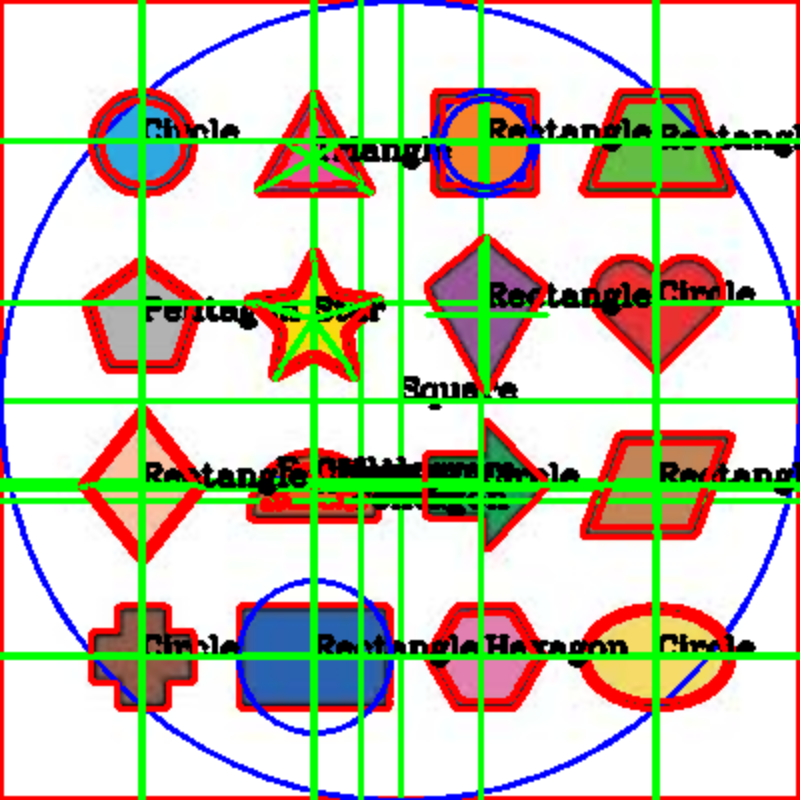

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow  # For displaying images in Colab

# Load image and convert to grayscale
img = cv2.imread("2d images.jpeg")
new_width = 400
aspect_ratio = new_width / img.shape[1]
new_height = int(img.shape[0] * aspect_ratio)
resized_img = cv2.resize(img, (new_width, new_height))

gray = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)

# Reduce noise by applying Gaussian blur
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Apply binary thresholding
_, threshold = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY)

# Find contours
contours, _ = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

def calculate_side_lengths(points):
    lengths = []
    for i in range(len(points)):
        x1, y1 = points[i]
        x2, y2 = points[(i + 1) % len(points)]
        length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
        lengths.append(length)
    return lengths

def calculate_angles(points):
    angles = []
    for i in range(len(points)):
        x1, y1 = points[i]
        x2, y2 = points[(i + 1) % len(points)]
        x3, y3 = points[(i + 2) % len(points)]
        angle = np.arccos(((x2 - x1) * (x3 - x2) + (y2 - y1) * (y3 - y2)) /
                          (np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2) *
                           np.sqrt((x3 - x2) ** 2 + (y3 - y2) ** 2)))
        angles.append(np.degrees(angle))
    return angles

def classify_shape(approx):
    num_vertices = len(approx)
    if num_vertices == 3:
        return "Triangle"
    elif num_vertices == 4:
        points = [tuple(pt[0]) for pt in approx]
        side_lengths = calculate_side_lengths(points)
        angles = calculate_angles(points)

        # Check for Square
        if np.allclose(side_lengths, side_lengths[0]) and \
           np.allclose(angles, 90):
            return "Square"

        # Check for Rhombus
        if np.allclose(side_lengths, side_lengths[0]) and \
           not np.allclose(angles, 90):
            return "Rhombus"

        # Check for Parallelogram
        if np.allclose(side_lengths[0], side_lengths[2]) and \
           np.allclose(side_lengths[1], side_lengths[3]) and \
           (np.allclose(angles[0], angles[2]) and np.allclose(angles[1], angles[3]) or \
            np.allclose(angles[0], 180 - angles[2]) and np.allclose(angles[1], 180 - angles[3])):
            return "Parallelogram"

        # Check for Kite
        if np.allclose(side_lengths[0], side_lengths[1]) and \
           np.allclose(side_lengths[2], side_lengths[3]):
            return "Kite"

        # Check for Trapezoid
        if np.any(np.isclose(side_lengths[0], side_lengths[2])) or \
           np.any(np.isclose(side_lengths[1], side_lengths[3])):
            return "Trapezoid"

        return "Rectangle"  # Default for 4-sided shapes not fitting other categories
    elif num_vertices == 5:
        return "Pentagon"
    elif num_vertices == 6:
        return "Hexagon"
    elif num_vertices == 10:
        return "Star"
    elif num_vertices > 15:
        return "Circle"
    return "Circle"

def draw_symmetry_lines(img, shape_name, approx):
    if shape_name == "Rectangle" or shape_name == "Square":
        rect = cv2.boundingRect(approx)
        x, y, w, h = rect
        # Draw vertical and horizontal lines of symmetry
        cv2.line(img, (x + w // 2, y), (x + w // 2, y + h), (0, 255, 0), 2)  # Vertical line
        cv2.line(img, (x, y + h // 2), (x + w, y + h // 2), (0, 255, 0), 2)  # Horizontal line
    elif shape_name == "Triangle":
        points = [tuple(pt[0]) for pt in approx]
        if len(points) == 3:
            for i in range(3):
                x1, y1 = points[i]
                x2, y2 = points[(i + 1) % 3]
                # Find midpoint of the opposite side
                mx, my = (points[(i + 2) % 3][0] + points[(i + 1) % 3][0]) // 2, (points[(i + 2) % 3][1] + points[(i + 1) % 3][1]) // 2
                # Draw median
                cv2.line(img, (x1, y1), (mx, my), (0, 255, 0), 2)
    elif shape_name == "Circle":
        M = cv2.moments(approx)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            # Draw vertical and horizontal lines through the center
            h, w = img.shape[:2]
            cv2.line(img, (cx, 0), (cx, h), (0, 255, 0), 2)  # Vertical line
            cv2.line(img, (0, cy), (w, cy), (0, 255, 0), 2)  # Horizontal line
    elif shape_name == "Star":
        points = [tuple(pt[0]) for pt in approx]
        if len(points) == 10:
            M = cv2.moments(approx)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                for i in range(0, len(points), 2):
                    x1, y1 = points[i]
                    x2, y2 = points[(i + 2) % 10]  # Opposite vertex in the star
                    cv2.line(img, (cx, cy), (x2, y2), (0, 255, 0), 2)
    elif shape_name == "Kite" or shape_name == "Rhombus":
        points = [tuple(pt[0]) for pt in approx]
        if len(points) == 4:
            # Draw diagonals for kites and rhombuses
            d1 = np.linalg.norm(np.array(points[0]) - np.array(points[2]))
            d2 = np.linalg.norm(np.array(points[1]) - np.array(points[3]))
            M = cv2.moments(approx)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                # Draw diagonals
                cv2.line(img, points[0], points[2], (0, 255, 0), 2)  # Diagonal 1
                cv2.line(img, points[1], points[3], (0, 255, 0), 2)  # Diagonal 2
    elif shape_name == "Parallelogram":
        points = [tuple(pt[0]) for pt in approx]
        if len(points) == 4:
            # Draw diagonals of the parallelogram
            cv2.line(img, points[0], points[2], (0, 255, 0), 2)  # Diagonal 1
            cv2.line(img, points[1], points[3], (0, 255, 0), 2)  # Diagonal 2
    elif shape_name == "Trapezoid":
        points = [tuple(pt[0]) for pt in approx]
        if len(points) == 4:
            # Draw line of symmetry (average of two non-parallel sides)
            x1, y1 = points[0]
            x2, y2 = points[1]
            x3, y3 = points[2]
            x4, y4 = points[3]
            midpoint1 = ((x1 + x2) / 2, (y1 + y2) / 2)
            midpoint2 = ((x3 + x4) / 2, (y3 + y4) / 2)
            cv2.line(img, (int(midpoint1[0]), int(midpoint1[1])), (int(midpoint2[0]), int(midpoint2[1])), (0, 255, 0), 2)

def complete_shape(img, contour):
    # Approximate contour to polygon
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)

    num_vertices = len(approx)
    if num_vertices == 4:
        points = [tuple(pt[0]) for pt in approx]
        side_lengths = calculate_side_lengths(points)
        angles = calculate_angles(points)

        # Complete quarter circle to full circle
        if num_vertices == 4 and (abs(angles[0] - 90) < 5 or abs(angles[1] - 90) < 5):
            # Example logic for completing incomplete shapes
            x, y, w, h = cv2.boundingRect(contour)
            center = (x + w // 2, y + h // 2)
            radius = max(w, h) // 2
            start_angle = 0
            end_angle = 360
            cv2.ellipse(img, center, (radius, radius), 0, start_angle, end_angle, (255, 0, 0), 2)

# Process each contour
for contour in contours:
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)

    M = cv2.moments(contour)
    if M["m00"] != 0:
        x = int(M["m10"] / M["m00"])
        y = int(M["m01"] / M["m00"])
    else:
        x, y = 0, 0

    shape_name = classify_shape(approx)
    cv2.putText(resized_img, shape_name, (x, y), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0), 2)

    cv2.drawContours(resized_img, [contour], -1, (0, 0, 255), 2)

    # Draw symmetry lines based on shape
    draw_symmetry_lines(resized_img, shape_name, approx)

    # Complete shapes if needed
    complete_shape(resized_img, contour)

# Scale up the image for display
scale_factor = 2
large_img = cv2.resize(resized_img, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_LINEAR)

# Display the result using cv2_imshow
cv2_imshow(large_img)


For example, here we download and display a PNG image of the Colab logo: